## Practical No: 7 - Lane and Curve detection for automatic Car

In [ ]:
import numpy as np
import sys
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from matplotlib.patches import Polygon
%matplotlib inline

### Camera Calibration  and Distortion Correction

In [ ]:
def cameraCalibrate(image):
    # Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    import glob

    #read in and make a list of calibration images
    images = glob.glob('/content/drive/MyDrive/camera_cal/calibration*.jpg')

    #Arrays to store objects points and image points from all the images
    objpoints = [] #3d points
    imgpoints = [] #2d points

    #prepare points
    objp  = np.zeros((9*6,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


    for fname in images:
        #read in each image
        img = mpimg.imread(fname)
        #convert image to gray scale  
        gray  = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        #find corners  
        ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    shape =(img.shape[1],img.shape[0])
    ret, mtx, dist, rvect, tvect = cv2.calibrateCamera(objpoints,imgpoints,shape,None,None)
    
    #undistored the image
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted_image

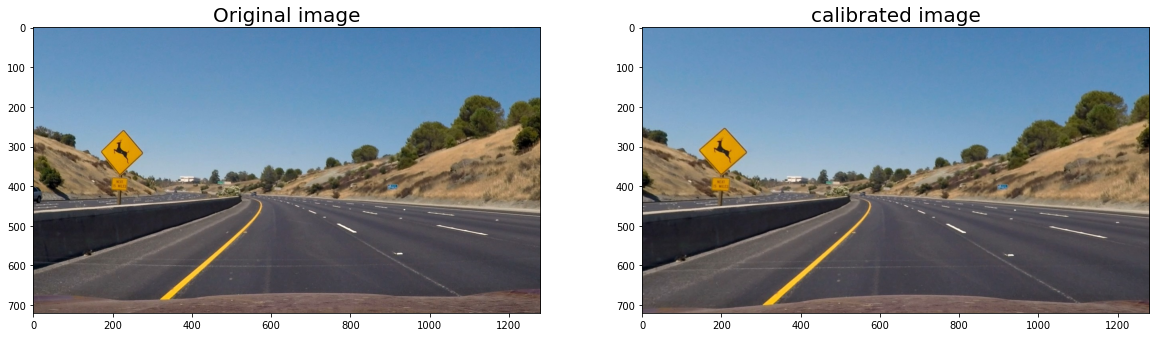

In [ ]:
test_image = mpimg.imread('/content/drive/MyDrive/test_images/test2.jpg')

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original image', fontsize=20)
ax1.imshow(test_image)

test_image=cameraCalibrate(test_image)
ax2.set_title('calibrated image', fontsize=20)
ax2.imshow(test_image)

### Gradient / Color Threshold

In [ ]:
#GAUSSIAN BLUR
blurred = cv2.GaussianBlur(test_image, (5,5), 0)

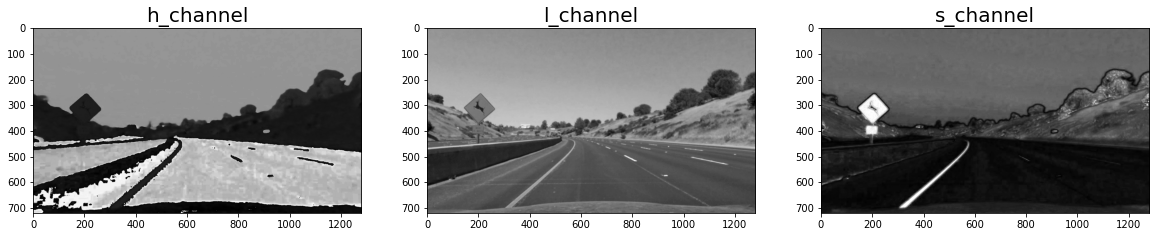

In [ ]:
#Convert to HLS
hlsval = cv2.cvtColor(blurred,cv2.COLOR_RGB2HLS)

h_channel,l_channel,s_channel=cv2.split(hlsval)
# visualize
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('h_channel', fontsize=20)
ax1.imshow(h_channel,cmap='gray')
ax2.set_title('l_channel', fontsize=20)
ax2.imshow(l_channel,cmap='gray')
ax3.set_title('s_channel', fontsize=20)
ax3.imshow(s_channel,cmap='gray')

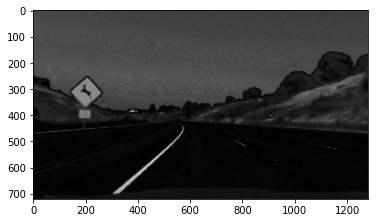

In [ ]:
plt.imshow((l_channel/255)*(s_channel/255),cmap="gray")

In [ ]:
def colorThreshold(img,thresh=(0.25,1)):
    hlsval = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    h_channel,l_channel,s_channel=cv2.split(hlsval)
    combinedcolor=(l_channel/255)*(s_channel/255)
    ret,thresh=cv2.threshold(combinedcolor,thresh[0],thresh[1],cv2.THRESH_BINARY)
    return thresh

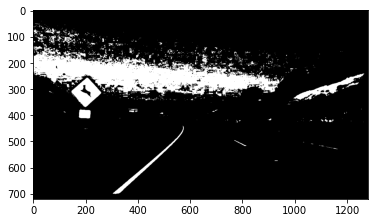

In [ ]:
plt.imshow(colorThreshold(test_image),cmap="gray")

In [ ]:
# X or Y sobel gradient
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 250)):
    # Convert to grayscale using cv2.COLOR_RGB2GRAY as the conversion
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function

    ddepth = cv2.CV_64F    
    # and take the absolute value
    if(orient=='x'):
        grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=sobel_kernel)
        abs_sobel=np.absolute(grad_x)
    if(orient=='y'):
        grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=sobel_kernel)
        abs_sobel=np.absolute(grad_y)   
    # Rescale back to 8 bit integer
    abs_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    abs_sobel_output = np.zeros_like(abs_sobel)
    for i in range(0,abs_sobel.shape[0]):
        for j in range(0,abs_sobel.shape[1]):
            if abs_sobel[i][j]>thresh[0] and abs_sobel[i][j]<thresh[1]:
                abs_sobel_output[i][j]=1   

    # Return the binary image
    return abs_sobel_output

# Magnitude using X and Y sobel gradient
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale using cv2.COLOR_RGB2GRAY as the conversion
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ddepth = cv2.CV_64F    
    
   
    # Calculate the gradient magnitude
    sobelx=np.absolute(cv2.Sobel(gray, ddepth, 1, 0, ksize=sobel_kernel))
    sobely=np.absolute(cv2.Sobel(gray, ddepth, 0, 1, ksize=sobel_kernel))
    
    sobelx=np.square(sobelx)
    sobely=np.square(sobely)
    sobelxy=sobelx+sobely
    gradmag=np.sqrt(sobelxy)
    
    # Rescale to 8 bit
    gradmag = np.uint8(255*gradmag/np.max(gradmag))
   
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    for i in range(0,gradmag.shape[0]):
        for j in range(0,gradmag.shape[1]):
            if gradmag[i][j]>mag_thresh[0] and gradmag[i][j]<mag_thresh[1]:
                mag_binary[i][j]=1     
    # Return the binary image
    return mag_binary

# Direction using X and Y sobel gradient
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale using cv2.COLOR_RGB2GRAY as the conversion
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ddepth = cv2.CV_64F     
    # Calculate the gradient direction using np.arctan2 function
    sobelx=cv2.Sobel(gray, ddepth, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, ddepth, 0, 1, ksize=sobel_kernel)
    absgraddir = np.absolute(np.arctan2(sobely, sobelx))
    # Rescale to 8 bit
    absgraddir = np.uint8(255*absgraddir/np.max(absgraddir))
   
    # Create a binary image of ones where threshold is met, zeros otherwise    
    dir_binary =  np.zeros_like(absgraddir)
    for i in range(0,absgraddir.shape[0]):
        for j in range(0,absgraddir.shape[1]):
            if absgraddir[i][j]>thresh[0] and absgraddir[i][j]<thresh[1]:
                dir_binary[i][j]=1     
    # Return the binary image
    return dir_binary

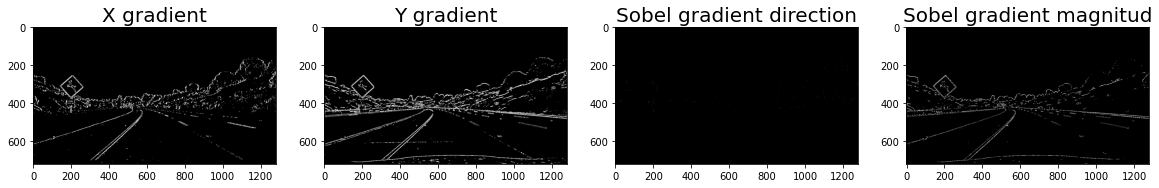

In [ ]:
colorGradientImage=colorThreshold(test_image)

# X gradient
x_sobel=abs_sobel_thresh(test_image,orient="x",thresh=(30, 100))
# Y gradient
y_sobel=abs_sobel_thresh(test_image,orient="y",thresh=(30, 100))
# Sobel gradient direction
mag_sobel=mag_thresh(test_image, sobel_kernel=3, mag_thresh=(60, 100))
# Sobel gradient magnitude
dir_sobel=dir_threshold(test_image, sobel_kernel=3, thresh=(0, np.pi/2))

# visualize results
f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,10))
# X gradient
ax1.set_title('X gradient', fontsize=20)
ax1.imshow(x_sobel,cmap='gray')
# Y gradient
ax2.set_title('Y gradient', fontsize=20)
ax2.imshow(y_sobel,cmap='gray')
# Sobel gradient direction
ax3.set_title('Sobel gradient direction', fontsize=20)
ax3.imshow(dir_sobel,cmap='gray')
# Sobel gradient magnitude
ax4.set_title('Sobel gradient magnitud', fontsize=20)
ax4.imshow(mag_sobel,cmap='gray')

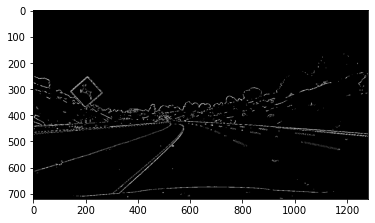

In [ ]:
image = mpimg.imread('/content/drive/MyDrive/test_images/test5.jpg')
plt.imshow(mag_thresh(test_image, mag_thresh=(60,100)), cmap='gray')

### Perspective Transform

In [ ]:
def warp(img, src_coordinates=None, dst_coordinates=None):

    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
 
    if src_coordinates is None:
        src_coordinates = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
        
    if dst_coordinates is None:
        dst_coordinates = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

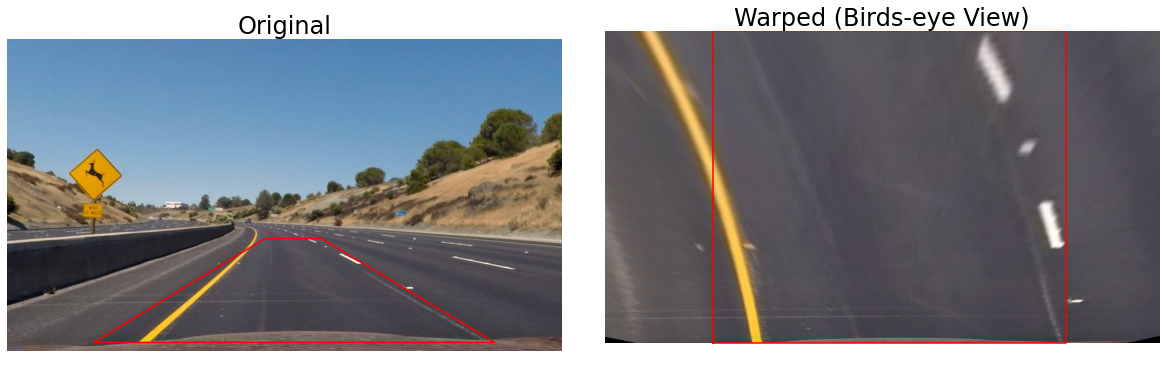

In [ ]:
src_coordinates = np.float32(
    [#[280,  700],
     [200, 700],# Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

dst_coordinates = np.float32(
    [[250,  720],   # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right   

coordinates = [src_coordinates,dst_coordinates]

#WARP BINARY IMAGE INTO TOP-DOWN VIEW
warped, M, Minv = warp(test_image, src_coordinates, dst_coordinates)

# Plot the result
imgs = [test_image, warped]
names = ['Original' ,'Warped (Birds-eye View)']

f, ax = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
i = 0
for c in range(2):
    ax[c].imshow(imgs[i], cmap='gray')
    ax[c].plot(Polygon(coordinates[i]).get_xy()[:, 0], Polygon(coordinates[i]).get_xy()[:, 1], color='red')
    warped, M, Minv = warp(test_image) #yasmeen's output
    ax[c].set_title('{}'.format(names[i]), fontsize=24)
    ax[c].axis('off')
    i += 1

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Detect Lane Lines

### 1- Histogram

In [ ]:
#The peaks int the histogram tell us about the likely position of the lanes in the image.
def find_histogram_peaks(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # Peak in the first half indicates the likely position of the left lane
    half_width = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:half_width])

    # Peak in the second half indicates the likely position of the right lane
    rightx_base = np.argmax(histogram[half_width:]) + half_width
    
    return histogram, leftx_base, rightx_base

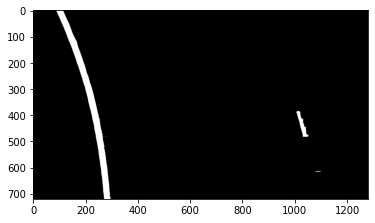

In [ ]:
#Make a binary image of the warped image
warped_binary = colorThreshold(warped)
plt.imshow(warped_binary, cmap='gray')

271 1031


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


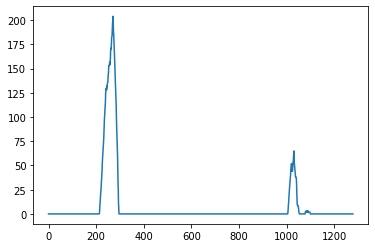

In [ ]:
#Get the histogram of the binary image
histogram, leftx_base, rightx_base = find_histogram_peaks(warped_binary)

print(leftx_base, rightx_base)
plt.plot(histogram)

### 2- Sliding Window

In [ ]:
def sliding_window(img, left_histogram_peak, right_histogram_peak, win_num=10, margin=80, min_pixels= 30):
    '''
    Parameters:
        win_num: number of sliding windows.
        margin: the width of each window.(+/-) margin
        min_pixels: used as a threshold to recenter the next sliding window - min num of white pixels found to recenter window
        w_height: computed from number of pixels and image height
    '''
    
    #Calculate height of the windows
    h = img.shape[0]//win_num
    w_height = np.int(h)
    
    # Calculate the pixels (x,y) of all white pixels in the image
    white_pixels = img.nonzero()
    white_pixels_y = np.array(white_pixels[0])
    white_pixels_x = np.array(white_pixels[1])
    
    # Current locations for left and right lanes
    left_lane_current_x = left_histogram_peak
    right_lane_current_x = right_histogram_peak
    
    # Create empty lists to receive left and right lane pixel indices
    right_lane_pos = []
    left_lane_pos = []
    
    #A blank image to display on it the lanes and the windows
    out_img = np.dstack((img, img, img))
    

    for win in range(win_num):
        #Get lower left, lower right, upper left and upper right Y positions of window
        lower_left_y = img.shape[0] - (win+1)*w_height
        lower_right_y = img.shape[0] - (win+1)*w_height
        upper_left_y = img.shape[0] - win*w_height
        upper_right_y = img.shape[0] - win*w_height
        #Get lower left, lower right, upper left and upper right X positions of window
        lower_left_x = left_lane_current_x - margin
        lower_right_x = right_lane_current_x - margin
        upper_left_x = left_lane_current_x + margin
        upper_right_x = right_lane_current_x + margin
        
        #Sketch left lane window
        cv2.rectangle(out_img,(lower_left_x,lower_left_y),(upper_left_x,upper_left_y),(0,255,0), 2) 
        #Sketch right lane window
        cv2.rectangle(out_img,(lower_right_x,lower_left_y),(upper_right_x,upper_left_y),(0,255,0), 2) 
    
        #Get the white pixels in x and y inside the window
        in_left_win = ((white_pixels_y >= lower_left_y) & (white_pixels_y < upper_left_y) & (white_pixels_x >= lower_left_x) & (white_pixels_x < upper_left_x)).nonzero()[0]
        in_right_win = ((white_pixels_y >= lower_right_y) & (white_pixels_y < upper_right_y) & (white_pixels_x >= lower_right_x) & (white_pixels_x < upper_right_x)).nonzero()[0]
        # Append these indices to the lists
        left_lane_pos.append(in_left_win)
        right_lane_pos.append(in_right_win)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(in_left_win) > min_pixels:
            left_lane_current_x = np.int(np.mean(white_pixels_x[in_left_win]))
        if len(in_right_win) > min_pixels:        
            right_lane_current_x = np.int(np.mean(white_pixels_x[in_right_win]))

    left_lane_pos = np.concatenate(left_lane_pos)
    right_lane_pos = np.concatenate(right_lane_pos)

    # Get the left and right line pixel positions
    leftx = white_pixels_x[left_lane_pos]
    lefty = white_pixels_y[left_lane_pos] 
    rightx = white_pixels_x[right_lane_pos]
    righty = white_pixels_y[right_lane_pos] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Draw left lane in blue
    out_img[white_pixels_y[left_lane_pos], white_pixels_x[left_lane_pos]] = [0, 0, 255]
    #Draw right lane in red
    out_img[white_pixels_y[right_lane_pos], white_pixels_x[right_lane_pos]] = [255, 0, 0]
    
    return left_fit, right_fit, out_img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

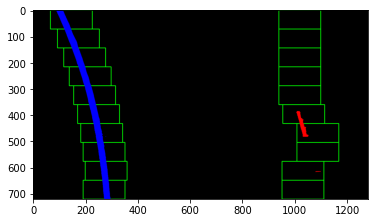

In [ ]:
left_fit, right_fit, out_img = sliding_window(warped_binary, leftx_base, rightx_base)
plt.imshow(out_img, cmap='gray')

In [ ]:
right_fit

array([2.00706352e-04, 1.30283963e-01, 9.32315973e+02])

In [ ]:
#draw lane
# left_fit and right_fit generated from step 9 in lane Detection
# bird_eye the image after thresholding and perspective transform
# read the inverse note below in the code
def draw_lane(img, bird_eye, left_fit, right_fit, Minv):
    tmp_image     = np.copy(img)
    if right_fit is None or left_fit is None:
        return img
    
    zero          = np.zeros_like(bird_eye).astype(np.uint8)
    layered_image = np.dstack((zero,zero,zero))
    
    ploty      = np.linspace(0, bird_eye.shape[0]-1, bird_eye.shape[0] )
    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    #formatting the points
    left   = np.array([np.transpose(np.vstack([right_fitx,ploty]))])
    right  = np.array([np.flipud(np.transpose(np.vstack([left_fitx,ploty])))])
    points = np.hstack((left,right))
    
    #form lane
    cv2.fillPoly(layered_image,np.int_([points]),(0,255,0))
    cv2.polylines(layered_image,np.int32([right]),isClosed = False,color=(255,0,0),thickness = 20)
    cv2.polylines(layered_image,np.int32([left]),isClosed = False,color=(255,0,0),thickness = 20)
    
    # The inverse perspective transfom note
    # use the inverse perspective option mentioned in the note above to transform back the layered_image
    #inversed = perspective_transform(layered_image,1)
    inversed = cv2.warpPerspective(layered_image, Minv, (img.shape[1], img.shape[0])) 
    
    output   = cv2.addWeighted(tmp_image,1,inversed,0.5,0)
    return left_fitx, right_fitx, output

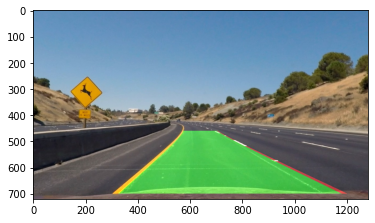

In [ ]:
left_fitx, right_fitx, output = draw_lane(test_image,warped_binary,left_fit,right_fit, Minv)
plt.imshow(output)

## Determine The Lane Curvature

In [ ]:
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    #print( ploty.size)
    #print( leftx.size)
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)

In [ ]:
# CALCULATE OFFSET DISTANCE AND ROAD CURVATURE

# Run the function
curvature_rads = curvature_radius(leftx=left_fitx, rightx= right_fitx, img_shape =  out_img.shape)

# Print the results
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')

Left line curvature: 474.2048683676097 m
Right line curvature: 649.693212455303 m


In [ ]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx

In [ ]:
offsetx = car_offset(leftx=left_fitx, rightx=right_fitx, img_shape=image.shape)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.30256352148100585 m.


In [ ]:
def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Calculate radius of curvature
    curvature_rads = curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

In [ ]:
def plot_result(imgs, names, rows=0, cols=0):
    '''
    plot the result
    '''
    if (len(imgs)==0 or len(names)==0): 
        return -1
    
    f, ax = plt.subplots(rows, cols, figsize=(16,8))
    f.tight_layout()
    i = 0
    if rows <= 1 :
        for c in range(cols):
            ax[c].imshow(imgs[i], cmap='gray')
            ax[c].set_title('{}'.format(names[i]), fontsize=24)
            ax[c].axis('off')
            i += 1
    else:
        for r in range(rows):
            for c in range(cols):
                ax[r, c].imshow(imgs[i], cmap='gray')
                ax[r, c].set_title('{}'.format(names[i]), fontsize=24)
                ax[r, c].axis('off')
                i += 1
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def pipeline(image):
    img1 = cameraCalibrate(image)
    src_coordinates = np.float32(
    [#[280,  700],
     [200, 700],# Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

    dst_coordinates = np.float32(
    [[250,  720],   # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right 
    img2, M, Minv= warp(img1, src_coordinates, dst_coordinates)
    img3 = colorThreshold(img2)
    histogram, leftx_base, rightx_base = find_histogram_peaks(img3)
    left_fit, right_fit, out_img = sliding_window(img3, leftx_base, rightx_base)
    left_fitx, right_fitx, output = draw_lane(img1,img3,left_fit,right_fit, Minv)

    curvature_rads = curvature_radius(leftx=left_fitx, rightx= right_fitx, 
                                      img_shape =  out_img.shape)
    offsetx = car_offset(leftx=left_fitx, rightx=right_fitx, img_shape=image.shape)
    out_img = add_metrics( output, left_fitx, right_fitx)
    return out_img

In [ ]:
def load_images(folder):
    images = []
    img_names = []
    for filename in os.listdir(folder):
        x=os.path.splitext(filename)
        if(x[1]==".jpg"):
            img = mpimg.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
                img_names.append(filename)
    return images,img_names

### Results

In [ ]:
images,img_names=load_images("/content/drive/MyDrive/test_images")
for i in range(0,len(images)):
    image=images[i]
    out=pipeline(image)
    imgs = [image, out]
    names = [img_names[i] ,'Lane detected with metrics']
    plot_result(imgs, names, 1, 2)

Output hidden; open in https://colab.research.google.com to view.